### Detección de picos R en ECG

In [1]:
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math



# Cargamos el archivo que contiene el ECG

 
da , info = wfdb.rdsamp( '105', pb_dir='mitdb/', sampfrom=0, sampto = 100000 , channels=[0])

print(info)

datos = pd.DataFrame({'hart':da[:,0]})

plt.title("ECG")
plt.xlim(0,2000)
plt.plot(datos.hart, alpha=0.8, color='red') #PLoteamos en semi transparente el ECG
plt.show()

{'fs': 360, 'sig_len': 100000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['MLII'], 'comments': ['73 F 1624 1629 x1', 'Digoxin, Nitropaste, Pronestyl', 'The PVCs are uniform.  The predominant feature of this tape is', 'high-grade noise and artifact.']}


<Figure size 640x480 with 1 Axes>

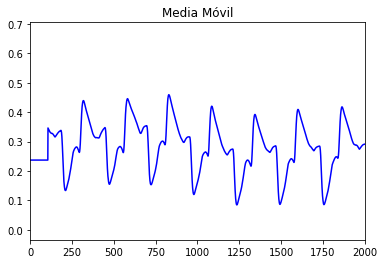

In [2]:
#Calculamos la media móvil a 0.5 en ambas direcciones y las agregamos al datos

hrw = 0.3 # Tamaño de la ventana
fs = info['fs'] # Fs a la que se tomó la muestra

media_mov = datos['hart'].rolling(int(hrw*fs)).mean() # calculamos la media móvil con 75 muestras de hart


#Cuando en el datos tenemos Nan (sería cuando empieza la muestra), colocamos el valor de la media de toda la medicion 

prom = (np.mean(datos.hart))

a = 0

for i in media_mov:
     if (math.isnan(i)):
         media_mov[a] = prom
         a = a+1
     else:
          media_mov[a] = i
          a = a+1
    
a = 0

#Aplicamos un offset del 20% a la media para que la señal t no interfiera 

for i in media_mov:
    media_mov[a] = abs(i)*1.1 #Aplicamos módulo
    a = a+1

#Agregamos la media móvil al set de datos

datos['ecg_mediamov'] = media_mov 

plt.title("Media Móvil")
plt.xlim(0,2000)
plt.plot(datos.ecg_mediamov, color='blue') 
plt.show()


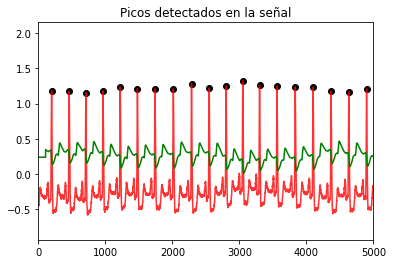

In [3]:
# Obtenemos los máximos

roi = []
picos_x = []
listpos = 0 # Usamos un contador para movernos entre los datos de las columnas

for punto in datos.hart:
    media = datos.ecg_mediamov[listpos] #Get local mean
    if (punto < media) and (len(roi) < 1): #Cuando no hay ECG grabado
        listpos += 1
    elif (punto > media): #Si el punto de la señal es mayor al punto de la media móvil, marcamos ROI
        roi.append(punto)
        listpos += 1
    else: #Si el punto de la media es mayor a la señal, determinamos extremo
        pico_x_local = listpos - len(roi) + (roi.index(max(roi))) #Guardamos en que punto del eje X está (Posicion donde termino ROI - Largo ROI + punto medio)
        picos_x.append(pico_x_local) #Agregamos el punto en x a la lista
        roi = [] #Limpiamos ROI. Se usa y se borra por cada ROI
        listpos += 1

# Guardamos el valor en Y de los picos
        
picos_y = [len(datos.hart)]
picos_y = [datos.hart[x] for x in picos_x] 


# Ploteamos

plt.title("Picos detectados en la señal")
plt.xlim(0,5000)
plt.plot(datos.hart, alpha=0.8, color='red') #PLoteamos en semi transparente el ECG
plt.plot(media_mov, color ='green') #Ploteamos media móvil en verde
plt.scatter(picos_x, picos_y, color='black') #Ploteamos picos en violeta
plt.show()


         X
0      197
1      458
2      708
3      964
4     1221
5     1478
6     1741
7     2015
8     2286
9     2550
10    2802
11    3052
12    3302
13    3563
14    3835
15    4102
16    4370
17    4635
18    4900
19    5154
20    5407
21    5562
22    5922
23    6195
24    6468
25    6736
26    6995
27    7246
28    7506
29    7766
..     ...
369  93059
370  93282
371  93330
372  93583
373  93828
374  94083
375  94354
376  94618
377  94884
378  95156
379  95351
380  95399
381  95422
382  95680
383  95935
384  96188
385  96445
386  96706
387  96985
388  97256
389  97521
390  97777
391  98030
392  98277
393  98541
394  98808
395  99077
396  99343
397  99616
398  99881

[399 rows x 1 columns]


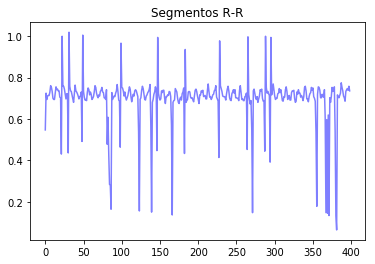

In [4]:


# Buscamos tiempos r-r 

r_r = pd.DataFrame({'X':picos_x})

print(r_r)
z = []

a = 0

for i in r_r['X']:
    if(a == 0):
        t = i
        a = a+1
        z.append(t)
    else:
        z.append(i-t)
        t = i

a = 0

for i in z:
    z[a] = (1/fs)*i
    a = a+1

r_r['tiempo'] = z

plt.figure()
plt.title("Segmentos R-R")
plt.plot(r_r['tiempo'], alpha=0.5, color='blue') #PLoteamos en semi transparente el R-R
plt.show()
